# Generate user, item, and interaction datasets for car search domain
This notebook is one of several provided to demonstrate the use of Amazon Personalize to 
provide recommendations for users searching for cars. This notebook generates the user, item, 
and interactions data, saves them as local csv files, and uploads them to S3 for use
in creating Personalize datasets to drive Personalize recommendation models.

A denormalized form of the interaction data is also saved for use in testing the models
and evaluating the resulting recommendations.

In [182]:
import numpy as np
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [183]:
import boto3

cars_filename         = 'car_items.csv'
users_filename        = 'users.csv'
interactions_filename = 'interactions.csv'
int_exp_filename      = 'interactions_expanded.csv'

bucket   = '<your-bucket>'
prefix   = 'personalize/v12'

## Define size for each generated dataset

In [184]:
NUM_INTERACTIONS = 750000
NUM_CARS         = 50000
NUM_USERS        = 30000

## Define various other parameters

Generated interactions are built as a set of "sessions". Each session is associated with
a single user and multiple car interactions. The timestamp for each interaction is 
separated by a configurable number of seconds.

In [185]:
SESSION_LEN           = 10
SESSION_DELAY_SECONDS = 2 * 60 # 2 minutes

NUM_SESSIONS = NUM_INTERACTIONS // SESSION_LEN

Define other parameters to control metadata for each car item.

In [186]:
MIN_YEAR    = 2009
MAX_YEAR    = 2019
MID_YEAR    = MIN_YEAR + ((MAX_YEAR - MIN_YEAR) // 2)

MIN_MILEAGE    = 1000
MAX_MILEAGE    = 200000
MILES_PER_YEAR = 15000

COLORS      = ['Red', 'Black', 'White', 'Blue']

In [187]:
MID_YEAR

2014

## Configure the set of car makes and models, plus zip codes

The car item data is driven by a configurable set of models. You can define which
makes and models are used by editing the `models.csv` file provided.

In [188]:
models_df = pd.read_csv('models.csv')
models_df = shuffle(models_df)
print(models_df.shape)

NUM_MODELS = models_df.shape[0]
NUM_CLUSTERS = NUM_MODELS * 2  # for each model, have an old car cluster and new car cluster
print('{} clusters based on {} models.'.format(NUM_CLUSTERS, NUM_MODELS))
models_df.head(NUM_MODELS)

(10, 4)
20 clusters based on 10 models.


,MAKE,MODEL,NUM_DOORS,BODY_TYPE
0,Toyota,Camry,4,sedan
6,Ford,Explorer,4,suv
2,Toyota,Rav4,4,suv
8,Nissan,Rogue,4,suv
1,Toyota,Sienna,4,minivan
4,Ford,Fusion,4,sedan
7,Nissan,Altima,4,sedan
9,Nissan,Leaf,4,sedan
3,Toyota,Prius,4,sedan
5,Ford,Mustang,4,sedan


The demo does not fully leverage location data for users and cars, but partial support
is provided in anticipation of adding that to the demo in the future.

In [189]:
zip_codes_df = pd.read_csv('zip_codes.csv')
print(zip_codes_df.shape)
zip_codes_df.head()

(100, 3)


,ZIP_CODE,CITY,INCOME
0,79936,El Paso TX,42857
1,90011,Los Angeles CA,23851
2,60629,Chicago IL,40279
3,90650,Norwalk CA,46012
4,90201,Bell Gardens CA,30029


## Generate data for the cars (items) dataset

### Generate make and model
Here we provide a normal distribution of Make/Model for our generated set of cars.
The mean is the midpoint of the number of total models, and the standard deviation is 
a quarter of the number of models. We make sure that no generated model falls outside the
bounds of the actual number of models.

In [190]:
def gen_normal_make_and_model():
    _idx = int(np.random.normal(NUM_MODELS // 2, NUM_MODELS // 4))
    _idx = min(NUM_MODELS - 1, _idx)
    _idx = max(0, _idx)
    return _idx

### Generate price
Here we determine a random price pased on age and miles.

In [191]:
def gen_price(age, miles):
    _price = 40000 - (3000 * age) + np.random.randint(0, 10000)
    _price = max(10000, _price)
    return _price

### Core function for generating cars (items)
Here we generate the set of items / cars to be recommended. We normally distribute the 
year of manufacture, and generate a random set of miles driven by the age of the car.

In [192]:
def gen_cars(num_cars):
    _car_inventory = []
    
    for i in range(num_cars):
        _year      = int(np.random.normal(2014, 2))
        _year      = min(MAX_YEAR, _year)
        
        _age       = MAX_YEAR - _year
        _mileage   = (MILES_PER_YEAR * _age) + np.random.randint(0, 10000)
        _price     = gen_price(_age, _mileage) 

        _model_idx = gen_normal_make_and_model()
        
#        _color_idx = np.random.randint(0, len(COLORS))
#        _loc_idx   = np.random.randint(0, _zip_len)
        
        _this_car = [str(i), models_df.iloc[_model_idx][0].strip(), 
                     models_df.iloc[_model_idx][1].strip(),
                     str(_year), _mileage, _price]
        #, COLORS[_color_idx], zip_codes_df.iloc[_loc_idx][0]]

        _car_inventory.append(_this_car)

    # not including color and location, due to personalize limit on num fields
    _df = pd.DataFrame(_car_inventory, columns=['ITEM_ID', 'MAKE', 'MODEL', 
                                                'YEAR', 'MILEAGE', 'PRICE'])
    return _df

In [193]:
cars_df = gen_cars(NUM_CARS)
print(cars_df.shape)
cars_df.head()

(50000, 6)


,ITEM_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE
0,0,Ford,Explorer,2015,62696,32711
1,1,Toyota,Sienna,2017,35036,36081
2,2,Nissan,Rogue,2012,105640,28920
3,3,Toyota,Prius,2015,61276,33745
4,4,Toyota,Sienna,2012,113328,23358


### Look at distribution of each car (item) feature

In [194]:
cars_df['MAKE'].value_counts()

Nissan    19457
Toyota    17558
Ford      12985
Name: MAKE, dtype: int64

In [195]:
cars_df['MODEL'].value_counts()

Sienna      9576
Fusion      9568
Altima      7439
Rogue       7322
Leaf        4696
Rav4        4650
Prius       2233
Explorer    2223
Mustang     1194
Camry       1099
Name: MODEL, dtype: int64

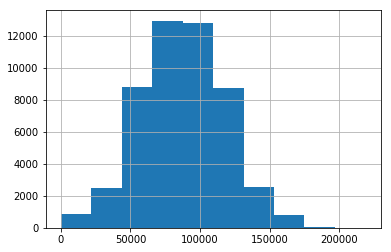

In [196]:
cars_df['MILEAGE'].hist()

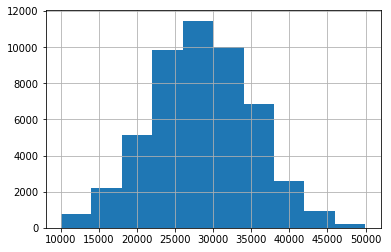

In [197]:
cars_df['PRICE'].hist()

## Generate data for users dataset
Here we normally distribute age of users, and uniformly distribute gender and location.

In [198]:
def gen_users(num_users):
    _users = []
    
    _zip_len = zip_codes_df.shape[0]
    
    for i in range(num_users):
        _age        = int(np.random.normal(40, 4))
        _gender_idx = np.random.randint(0, 2)
        _loc_idx    = np.random.randint(0, _zip_len)
        if _gender_idx == 0:
            _gender = 'MALE'
        else:
            _gender = 'FEMALE'
            
        _this_user = [str(i), _age, _gender, 
                      str(zip_codes_df.iloc[_loc_idx][0]), 
                      zip_codes_df.iloc[_loc_idx][2]]
        
        _users.append(_this_user)
        
    _df = pd.DataFrame(_users, columns=['USER_ID', 'AGE', 'GENDER', 'LOCATION', 'SALARY'])
    return _df

In [199]:
users_df = gen_users(NUM_USERS)
print(users_df.shape)
users_df.head()

(30000, 5)


,USER_ID,AGE,GENDER,LOCATION,SALARY
0,0,44,FEMALE,90044,22091
1,1,34,FEMALE,90201,30029
2,2,37,MALE,89110,43073
3,3,34,MALE,78572,23799
4,4,44,MALE,60625,40083


### Look at the distribution of each user feature

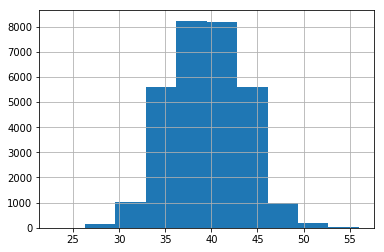

In [200]:
users_df['AGE'].hist()

In [201]:
users_df['LOCATION'].value_counts()[0:10]

90650    347
90706    346
8701     336
92336    330
91744    330
92553    330
93550    329
60618    328
89110    328
10456    328
Name: LOCATION, dtype: int64

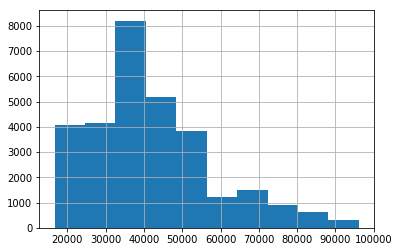

In [202]:
users_df['SALARY'].hist()

In [203]:
print('Car count: {}, User count: {}'.format(NUM_CARS, NUM_USERS))

Car count: 50000, User count: 30000


## Generate interactions dataset

### Helper function for normal distribution of interaction items

In [204]:
def gen_normal_item_indices(num_indices, num_items, std_div=10):
    _loc = num_indices // 2
    _std = num_indices // std_div

    _tmp = np.random.normal(loc=_loc, scale=_std, size=num_items)
    _tmp = _tmp.astype(int)

    num_bins = 50
    _a, _b, _c = plt.hist(_tmp, num_bins)
    
    return _tmp

### Add columns to users that will drive a predictable set of interactions
Interactions will be generated on a per-user basis. Here we define what set of cars
a user will be viewing. We do this by defining a set of "car clusters". A car cluster
is the set of cars that all have the same make and model, plus an age preference.
For example, some users will prefer Old Toyota Camry's. Others will like New Ford Explore's.

The `FAV_CLUSTER` feature is an integer representing the user's favorit car cluster. The `FAV` 
feature is a text version that makes it easier to understand the car cluster when looking
at the data during testing and model assessment. These features are NOT saved as part of
the Amazon Personalize datasets, but ARE saved as part of the expanded interactions data
that is saved for helping in the model usage notebook.

10    3987
9     3971
8     3465
11    3445
12    2883
7     2826
13    2053
6     1934
14    1313
5     1292
4      759
15     710
16     398
3      377
2      172
17     172
18      83
1       71
19      47
0       42
Name: FAV_CLUSTER, dtype: int64

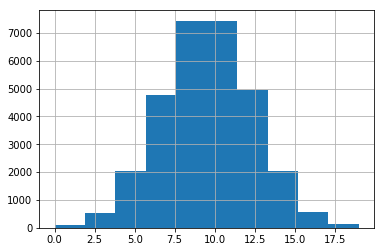

In [205]:
def set_fav(user_id):
    _fav = int(np.random.normal(NUM_CLUSTERS // 2, NUM_CLUSTERS // 6))
    _fav = min(NUM_CLUSTERS - 1, _fav)
    _fav = max(0, _fav)
    return _fav

users_df['FAV_CLUSTER'] = users_df['USER_ID'].apply(set_fav)
users_df['FAV_CLUSTER'].hist()
users_df['FAV_CLUSTER'].value_counts()

4    7436
5    7432
6    4936
3    4760
2    2051
7    2023
8     570
1     549
9     130
0     113
Name: FAV_MODEL, dtype: int64

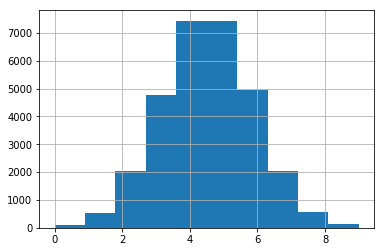

In [206]:
users_df['FAV_MODEL'] = users_df['FAV_CLUSTER'] // 2
users_df['FAV_MODEL'].hist()
users_df['FAV_MODEL'].value_counts()

In [207]:
def set_fav_text(cluster):
    fav_model = cluster // 2
    if cluster % 2 == 0:
        age = 'NEWISH'
    else:
        age = 'OLDISH'
    return  '{}-{}-{}'.format(age,
                              models_df.iloc[fav_model]['MAKE'], 
                              models_df.iloc[fav_model]['MODEL'])
users_df['FAV'] = users_df['FAV_CLUSTER'].apply(set_fav_text)
users_df['FAV'].value_counts()

NEWISH-Ford-Fusion      3987
OLDISH-Toyota-Sienna    3971
NEWISH-Toyota-Sienna    3465
OLDISH-Ford-Fusion      3445
NEWISH-Nissan-Altima    2883
OLDISH-Nissan-Rogue     2826
OLDISH-Nissan-Altima    2053
NEWISH-Nissan-Rogue     1934
NEWISH-Nissan-Leaf      1313
OLDISH-Toyota-Rav4      1292
NEWISH-Toyota-Rav4       759
OLDISH-Nissan-Leaf       710
NEWISH-Toyota-Prius      398
OLDISH-Ford-Explorer     377
OLDISH-Toyota-Prius      172
NEWISH-Ford-Explorer     172
NEWISH-Ford-Mustang       83
OLDISH-Toyota-Camry       71
OLDISH-Ford-Mustang       47
NEWISH-Toyota-Camry       42
Name: FAV, dtype: int64

### Helper functions

In [208]:
def print_item(item_id):
    tmp = cars_df[cars_df.ITEM_ID == item_id].iloc[0]
    print('Id: {}, Make: {}, Model: {}, Miles: {}, Year: {}, Price: {}, Age: {}'.format(item_id,
         tmp['MAKE'], tmp['MODEL'], tmp['MILEAGE'], tmp['YEAR'], tmp['PRICE'], tmp['AGE']))

In [209]:
def print_car_cluster(c):
    print(len(c))
    print(c)

### Generate a normal distribution of random cars for a given car cluster

In [210]:
def gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size):
    _car_cluster = _fav_cars[_which_cluster]
    _cluster_len = len(_car_cluster)

    _idx_list = np.random.normal(loc=_cluster_len // 2, 
                                 scale=_cluster_len // 10, 
                                 size=_sample_size)
    _idx_list = _idx_list.astype(int)
    
    # We want to maximize how many specific car items are involved in the generated
    # interactions. However, the more we push the envelope, the more likely it is that
    # a generated index is outside of bounds. Here we catch and resolve those situations.
    if max(_idx_list) > (_cluster_len - 1):
#        print('*** idx too big: {}, len: {}'.format(max(_idx_list), _cluster_len))
        _idx_of_max = np.argmax(_idx_list)
        _idx_list[_idx_of_max] = _cluster_len // 2
        new_max = max(_idx_list)
#        print('===== new max is {}'.format(new_max))
        if (new_max > (_cluster_len - 1)):
            _idx_of_max = np.argmax(_idx_list)
            _idx_list[_idx_of_max] = _cluster_len // 2
            new_max = max(_idx_list)
#            print('=====//// new new max is {}'.format(new_max))

    return _car_cluster.iloc[_idx_list]['ITEM_ID'].values

In [211]:
def pick_random_normal_car(car_cluster):
    _cluster_len = car_cluster.shape[0]
    _idx = np.random.normal(loc=_cluster_len // 2,
                            scale=_cluster_len // 10,
                            size=1)
    _item_id = car_cluster.iloc[_idx]['ITEM_ID'].values[0]
    return _item_id

### Core function for generating interactions

In [212]:
def gen_interactions(num_interactions):
    _interactions = []
    
    _num_users = users_df.shape[0]
    _num_items = cars_df.shape[0]
    
    # generate interactions as sets of interactions separated by a few mins
    # by same user on different items
    _session_len = SESSION_LEN
    _num_sessions = num_interactions // _session_len
    print('Generating {} sessions of length {}, total: {}...'.format(_num_sessions, 
                                                                     _session_len,
                                                                     num_interactions))

    # One-time generation of the list of cars that match each possible cluster of
    # favorite cars. A random selection of these will be used in each session.
    _fav_cars = []
    for c in range(NUM_CLUSTERS):
        m = c // 2
        _make  = models_df.iloc[m]['MAKE']
        _model = models_df.iloc[m]['MODEL']
        if c % 2 == 0:
            # newish
            _car_cluster = cars_df[(cars_df.YEAR >= str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]
        else:
            # oldish
            _car_cluster = cars_df[(cars_df.YEAR < str(MID_YEAR)) &
                                       (cars_df.MAKE  == _make) &
                                       (cars_df.MODEL == _model)]

        _fav_cars.append(_car_cluster)

    # Generate a set of user_id's to be used, one per session
    _which_user_idx = gen_normal_item_indices(_num_users, _num_sessions, std_div=6)

    # Session start times will be randomly picked to happen between now and 48 hours ago
    _latest_time   = round(datetime.now().timestamp())
    _earliest_time = _latest_time - (60*48)
    
    for s in range(_num_sessions):
        if (s % 10000 == 0):
            print('...at session {}'.format(s))
            
        _user = _which_user_idx[s]
        
        # ensure user id is within bounds
        if (_user < 0):
            _user = np.random.randint(0, NUM_USERS - 1)
        elif (_user > (NUM_USERS - 1)):
            _user = np.random.randint(0, NUM_USERS - 1)
            
        # Use same car cluster for every interaction in the current session
        _which_cluster  = users_df.iloc[_user]['FAV_CLUSTER']

        # Pick a random session start time
        _when = np.random.randint(_earliest_time, _latest_time)
        
        # Generate a set of specific cars to use in this session. Choose them
        # only from the designated car cluster preferred by this user.
        _sample_size = num_interactions // NUM_CLUSTERS
        _session_cars = gen_normal_from_cluster(_fav_cars, _which_cluster, _sample_size)

        for i in range(_session_len):
            interaction_num = (s * _session_len) + i
            idx = interaction_num % NUM_CLUSTERS

            _item = _session_cars[idx]

            _when = _when + (i * SESSION_DELAY_SECONDS) 

            _this_interaction = [str(_user), str(_item), _when, s]

            _interactions.append(_this_interaction)
        
    _df = pd.DataFrame(_interactions, columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'SESSION_ID'])
    return _df

Generating 75000 sessions of length 10, total: 750000...
...at session 0
...at session 10000
...at session 20000
...at session 30000
...at session 40000
...at session 50000
...at session 60000
...at session 70000
CPU times: user 14min 17s, sys: 170 ms, total: 14min 17s
Wall time: 14min 17s


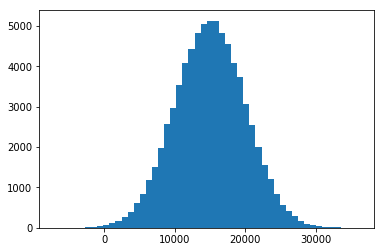

In [213]:
%%time
interactions_df = gen_interactions(NUM_INTERACTIONS)
interactions_df.head()

### Show utilization and distribution of interactions per user and per item

In [214]:
_user_vc = interactions_df['USER_ID'].value_counts()
print('{:.2f} of users have interactions ({}/{})'.format(_user_vc.shape[0]/NUM_USERS,
                                                        _user_vc.shape[0],
                                                        NUM_USERS))
print('First 10: \n{}'.format(_user_vc[:10]))
print('Last 10:  \n{}'.format(_user_vc[-10:]))

0.69 of users have interactions (20762/30000)
First 10: 
14198    160
16310    150
15559    150
16744    150
17917    140
15947    140
12638    140
16850    140
15009    140
14956    140
Name: USER_ID, dtype: int64
Last 10:  
19308    10
22948    10
8734     10
22876    10
18779    10
24034    10
27232    10
16732    10
27694    10
23393    10
Name: USER_ID, dtype: int64


In [215]:
print('{:.2f} of ITEMS have interactions ({}/{})'.format(interactions_df['ITEM_ID'].value_counts().shape[0]/NUM_CARS,
                                                      interactions_df['ITEM_ID'].value_counts().shape[0],
                                                       NUM_CARS))
_item_vc = interactions_df['ITEM_ID'].value_counts()
print('First 10: \n{}'.format(_item_vc[:10]))
print('Last 10:  \n{}'.format(_item_vc[-10:]))

0.60 of ITEMS have interactions (29798/50000)
First 10: 
24343    111
24564    110
25645    109
24189    108
25762    107
24567    106
24794    105
25897    105
24259    104
25640    104
Name: ITEM_ID, dtype: int64
Last 10:  
43446    1
10229    1
17569    1
40851    1
13351    1
8575     1
38978    1
40190    1
39420    1
39966    1
Name: ITEM_ID, dtype: int64


## Drop inactive users and items

In [216]:
active_users   = pd.DataFrame(interactions_df['USER_ID'].value_counts()).index
inactive_users = users_df[~users_df.USER_ID.isin(active_users)]
print('{} users have NO interactions'.format(inactive_users.shape[0]))
inactive_users.head()

9238 users have NO interactions


,USER_ID,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV
0,0,44,FEMALE,90044,22091,12,6,NEWISH-Nissan-Altima
1,1,34,FEMALE,90201,30029,6,3,NEWISH-Nissan-Rogue
2,2,37,MALE,89110,43073,7,3,OLDISH-Nissan-Rogue
3,3,34,MALE,78572,23799,8,4,NEWISH-Toyota-Sienna
4,4,44,MALE,60625,40083,4,2,NEWISH-Toyota-Rav4


In [217]:
active_items   = pd.DataFrame(interactions_df['ITEM_ID'].value_counts()).index
inactive_items = cars_df[~cars_df.ITEM_ID.isin(active_items)]
print('{} items have NO interactions'.format(inactive_items.shape[0]))
inactive_items.head()

20202 items have NO interactions


,ITEM_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE
0,0,Ford,Explorer,2015,62696,32711
1,1,Toyota,Sienna,2017,35036,36081
2,2,Nissan,Rogue,2012,105640,28920
3,3,Toyota,Prius,2015,61276,33745
4,4,Toyota,Sienna,2012,113328,23358


In [218]:
cars_df.drop(inactive_items.index, inplace=True)
print('After dropping inactive cars, {} remain.'.format(cars_df.shape))

After dropping inactive cars, (29798, 6) remain.


In [219]:
users_df.drop(inactive_users.index, inplace=True)
print('After dropping inactive users, {} remain.'.format(users_df.shape))

After dropping inactive users, (20762, 8) remain.


## Create an expanded interactions dataframe for analysis
The interactions dataframe to pass to Personalize is limited to 5 metadata items
and is conforming to a schema we will define in another notebook. This expanded 
dataframe helps with framing tests and evaluating results, as in creates one big
denormalized dataframe with interactions and corresponding user and car features.

In [220]:
interactions_expanded_df = pd.merge(interactions_df, cars_df, on='ITEM_ID')
interactions_expanded_df = pd.merge(interactions_expanded_df, users_df, on='USER_ID')
interactions_expanded_df.head()

,USER_ID,ITEM_ID,TIMESTAMP,SESSION_ID,MAKE,MODEL,YEAR,MILEAGE,PRICE,AGE,GENDER,LOCATION,SALARY,FAV_CLUSTER,FAV_MODEL,FAV
0,10953,28159,1563132741,0,Toyota,Sienna,2010,138051,18029,37,FEMALE,926,26306,9,4,OLDISH-Toyota-Sienna
1,10953,31969,1563132861,0,Toyota,Sienna,2012,106905,28964,37,FEMALE,926,26306,9,4,OLDISH-Toyota-Sienna
2,10953,29623,1563133101,0,Toyota,Sienna,2013,97038,28016,37,FEMALE,926,26306,9,4,OLDISH-Toyota-Sienna
3,10953,26740,1563133461,0,Toyota,Sienna,2013,93337,22521,37,FEMALE,926,26306,9,4,OLDISH-Toyota-Sienna
4,10953,15404,1563133941,0,Toyota,Sienna,2013,97747,26073,37,FEMALE,926,26306,9,4,OLDISH-Toyota-Sienna


## Display overall statistics

In [221]:
eps_stats = pd.DataFrame(interactions_df['SESSION_ID'].value_counts()).describe()
epi_stats = pd.DataFrame(interactions_df['ITEM_ID'].value_counts()).describe()
epu_stats = pd.DataFrame(interactions_df['USER_ID'].value_counts()).describe()
spu_stats = interactions_df.groupby('USER_ID')['SESSION_ID'].nunique().to_frame().describe()

In [222]:
item_count = cars_df.shape[0]
user_count = users_df.shape[0]
interaction_count = interactions_df.shape[0]

print('{:,} items\n{:,} users\n{:,} interactions\n{:,} sessions'.format(item_count, 
                                                                user_count, 
                                                                interaction_count, 
                                                                NUM_SESSIONS))
print('\nevents per session (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(eps_stats.loc['mean'].values[0],
                                                               eps_stats.loc['50%'].values[0],
                                                               eps_stats.loc['std'].values[0]))
print('events per item    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epi_stats.loc['mean'].values[0],
                                                                           epi_stats.loc['50%'].values[0],
                                                                           epi_stats.loc['std'].values[0]))
print('events per user    (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(epu_stats.loc['mean'].values[0],
                                                                           epu_stats.loc['50%'].values[0],
                                                                           epu_stats.loc['std'].values[0]))
print('sessions per user  (median/mean/stdev) {:.2f}/{:.2f}/{:.2f}'.format(spu_stats.loc['mean'].values[0],
                                                                           spu_stats.loc['50%'].values[0],
                                                                           spu_stats.loc['std'].values[0]))

print('\n{:.2f} of items have interactions ({}/{})'.format(interactions_df['ITEM_ID'].value_counts().shape[0]/item_count,
                                                      interactions_df['ITEM_ID'].value_counts().shape[0],
                                                       item_count))
print('{:.2f} of users have interactions ({}/{})'.format(_user_vc.shape[0]/user_count,
                                                        _user_vc.shape[0],
                                                        user_count))

29,798 items
20,762 users
750,000 interactions
75,000 sessions

events per session (median/mean/stdev) 10.00/10.00/0.00
events per item    (median/mean/stdev) 25.17/16.00/24.66
events per user    (median/mean/stdev) 36.12/30.00/24.24
sessions per user  (median/mean/stdev) 3.61/3.00/2.42

1.00 of items have interactions (29798/29798)
1.00 of users have interactions (20762/20762)


## Save data to S3 and expanded interactions to local csv

In [223]:
cars_df.to_csv(cars_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, cars_filename)).upload_file(cars_filename)

In [224]:
users_df.to_csv(users_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, users_filename)).upload_file(users_filename)

In [225]:
interactions_df[['USER_ID', 'ITEM_ID', 'TIMESTAMP']].to_csv(interactions_filename, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}'.format(prefix, interactions_filename)).upload_file(interactions_filename)

In [226]:
interactions_expanded_df.to_csv(int_exp_filename, index=False)